> Adapted from *Machine Learning with PyTorch and Scikit-Learn* by Raschka et al.  
> Figures and selected functions used under CC BY-NC 4.0.  
> Markdown content and examples modified for educational use in neuroscience.

# A Tour of Machine Learning Classifiers  
**Chapter 3/3 — Adapted for SNEU20007U Computational Neuroscience**

In this notebook, we explore key supervised learning algorithms for classification, focusing on:
- Logistic Regression
- Support Vector Machines (SVM)
- Kernel SVMs

We apply these tools to a 3-class synthetic dataset of neurons — `Interneuron`, `Pyramidal`, and `Bursting` — described by spike waveform features. These examples replace the traditional `iris` dataset.


In [9]:
from ch03_expanded import load_synthetic_neurons_3class

# Load data
X, y, df = load_synthetic_neurons_3class(as_frame=True, overlap=1.5)
df.head()


,spike_width,amplitude,upstroke_downstroke,symmetry_index,neuron_type
0,0.272854,32.200119,1.425135,0.941085,Interneuron
1,0.103672,30.233654,1.238352,0.752564,Interneuron
2,0.248740,33.602171,1.463819,0.916669,Interneuron
3,0.254952,48.454309,1.340253,0.671106,Interneuron
4,0.277656,32.808380,1.463535,0.792511,Interneuron


## 4. Modeling Class Probabilities via Logistic Regression

Logistic regression is a **linear classifier** that models the **probability** that a sample belongs to a given class. Unlike the perceptron, which only outputs a class label, logistic regression provides **real-valued probabilities**, which are particularly useful in medical and neuroscience settings where uncertainty matters.

For binary classification, the logistic regression model uses the **logistic sigmoid function**:

$$
P(y = 1 \mid \mathbf{x}) = \frac{1}{1 + e^{-z}}, \quad \text{where } z = \mathbf{w}^T \mathbf{x} + b
$$

This expression maps any real-valued input to a value between 0 and 1. The model estimates the probability that the sample belongs to class 1, and class 0 is simply the complement.

<img src="./figures/03_02.png" width="600">


### Log-Odds Interpretation

Instead of modeling class labels directly, logistic regression models the **log-odds** (or *logit*) of the positive class:

$$
\log \left( \frac{P(y = 1 \mid \mathbf{x})}{1 - P(y = 1 \mid \mathbf{x})} \right) = \mathbf{w}^T \mathbf{x} + b
$$

This linear relationship between the features and the log-odds makes logistic regression interpretable and effective for linearly separable data.

<img src="./figures/03_03.png" width="600">

### Training: The Logistic Loss

The logistic regression model is trained by minimizing the **log-loss** (also known as binary cross-entropy):

$$
\mathcal{L} = - \sum_{i=1}^{n} \left[ y^{(i)} \log(\hat{p}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{p}^{(i)}) \right]
$$

Where:
- $y^{(i)}$ is the true label
- $\hat{p}^{(i)}$ is the predicted probability for class 1

This loss function penalizes incorrect predictions more severely when the model is confident but wrong.

<!-- <img src="./figures/03_25.png" width="600"> -->

### From Binary to Multiclass Classification

For problems with more than two classes (like our 3-class synthetic neuron dataset), logistic regression can be extended using either:

- **One-vs-Rest (OvR)**: Train a separate binary classifier for each class vs. the rest
- **Multinomial (Softmax)**: Generalize the sigmoid function to output a probability distribution over all classes

Scikit-learn's `LogisticRegression` supports both approaches and defaults to **multinomial** when using the `'lbfgs'` solver and `multi_class='multinomial'`.

We will now train a logistic regression model on our **standardized synthetic neuron waveform dataset**, and visualize how well it separates the neuron types in feature space.


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Preprocess
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Train logistic regression
lr = LogisticRegression(multi_class='ovr', solver='lbfgs', C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8444444444444444


c:\Users\jhc23\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


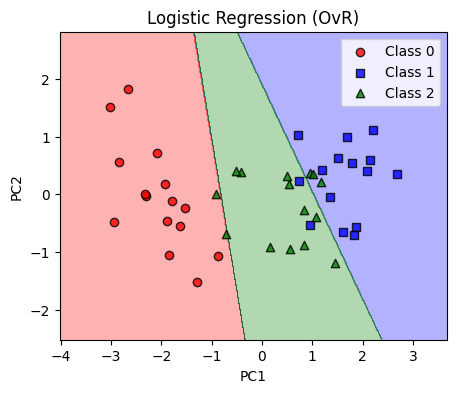

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, title="", resolution=0.02):
    # Only use first 2 PCA components
    pca = PCA(n_components=2)
    X_proj = pca.fit_transform(X)
    
    markers = ('o', 's', '^')
    colors = ('red', 'blue', 'green')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X_proj[:, 0].min() - 1, X_proj[:, 0].max() + 1
    x2_min, x2_max = X_proj[:, 1].min() - 1, X_proj[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(pca.inverse_transform(np.array([xx1.ravel(), xx2.ravel()]).T))
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X_proj[y == cl, 0], y=X_proj[y == cl, 1],
                    alpha=0.8, c=colors[idx], marker=markers[idx], label=f'Class {cl}',
                    edgecolor='black')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.legend()

# Plot decision boundary
plt.figure(figsize=(5,4))
plot_decision_regions(X_test_std, y_test, classifier=lr, title="Logistic Regression (OvR)")
plt.show()
